# Imports and setup

In [1]:
import astropy.coordinates as coord
import astropy.table as at
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import cmasher as cmr

%matplotlib inline
import numpy as np
import gala.coordinates as gc

from jax.config import config

config.update("jax_enable_x64", True)
import jax
import jax.numpy as jnp
import jaxopt

import arviz as az
import numpyro

numpyro.enable_x64()
numpyro.set_host_device_count(2)
#from numpyro_ext.optim import optimize
from numpyro import infer

from pyia import GaiaData

import scipy.optimize as sco
import scipy.interpolate as sci
import scipy.stats as scs
import scipy.ndimage as scn
import scipy.special as scsp

import sys
sys.path.append('../../stream-membership')
sys.path.append('../')
sys.path.append('../../CATS_workshop/cats/')
from stream_membership import StreamMixtureModel
from stream_membership.plot import plot_data_projections
from gd1_helpers.membership import (
    GD1Base,
    GD1BackgroundModel,
    GD1StreamModel,
    GD1OffTrackModel,
)

        Use @ instead. [gala.coordinates.sgr]
        Use @ instead. [gala.coordinates.orphan]
        Use @ instead. [gala.coordinates.magellanic_stream]


In [2]:
cmap = plt.get_cmap('cmr.ember_r')
mpl.rc('image', cmap=cmap.name)

In [3]:
import importlib
importlib.reload(sys.modules['gd1_helpers.membership'])
importlib.reload(sys.modules['gd1_helpers.membership.gd1_model'])
importlib.reload(sys.modules['stream_membership'])
importlib.reload(sys.modules['stream_membership'])
from gd1_helpers.membership import (
    GD1Base,
    GD1BackgroundModel,
    GD1StreamModel,
    GD1OffTrackModel,
)
from stream_membership import StreamMixtureModel
from stream_membership.plot import plot_data_projections

In [4]:
data = at.Table.read("../../CATS_Workshop/cats/data/joined-GD-1.fits")

#data = at.Table.read('../data/tmp/run_data.fits')
#masks = at.Table.read('../data/tmp/run_data_masks.fits')
cat = data
cat['pm1'] = cat['pm_phi1_cosphi2_unrefl']
cat['pm2'] = cat['pm_phi2_unrefl']

In [5]:
from cats.pawprint.pawprint import Pawprint, Footprint2D
from cats.CMD import Isochrone
from cats.inputs import stream_inputs as inputs
from cats.proper_motions import ProperMotionSelection, rough_pm_poly

stream='GD-1'


p = Pawprint.pawprint_from_galstreams(inputs[stream]['short_name'],
                                      inputs[stream]['pawprint_id'],
                                      width=inputs[stream]['width'] * u.deg)

# rough pm cut to start with (this comes only from the galstreams proper motion tracks)
p.pmprint, pm_mask = rough_pm_poly(p, cat, buffer=3)

# Create the CMD cuts
o = Isochrone(stream, cat, pawprint=p)
_, iso_mask, _, hb_mask, pprint = o.simpleSln(maxmag=22, mass_thresh=0.83)

A new version of galpy (1.9.1) is available, please upgrade using pip/conda/... to get the latest features and bug fixes!


        Use @ instead. [gala.coordinates.greatcircle]


-40.18182128833206
Fitting for peak pm location
Pre-fitting mean PM values: -13.031354268696703, -3.10816045358226
Post-fitting (pm1_mean, pm2_mean, pm1_std, pm2_std): [-13.299030895391816, -3.178220550031381, 0.3944380722056084, 0.517241359741969] 

Producing the polygon and mask


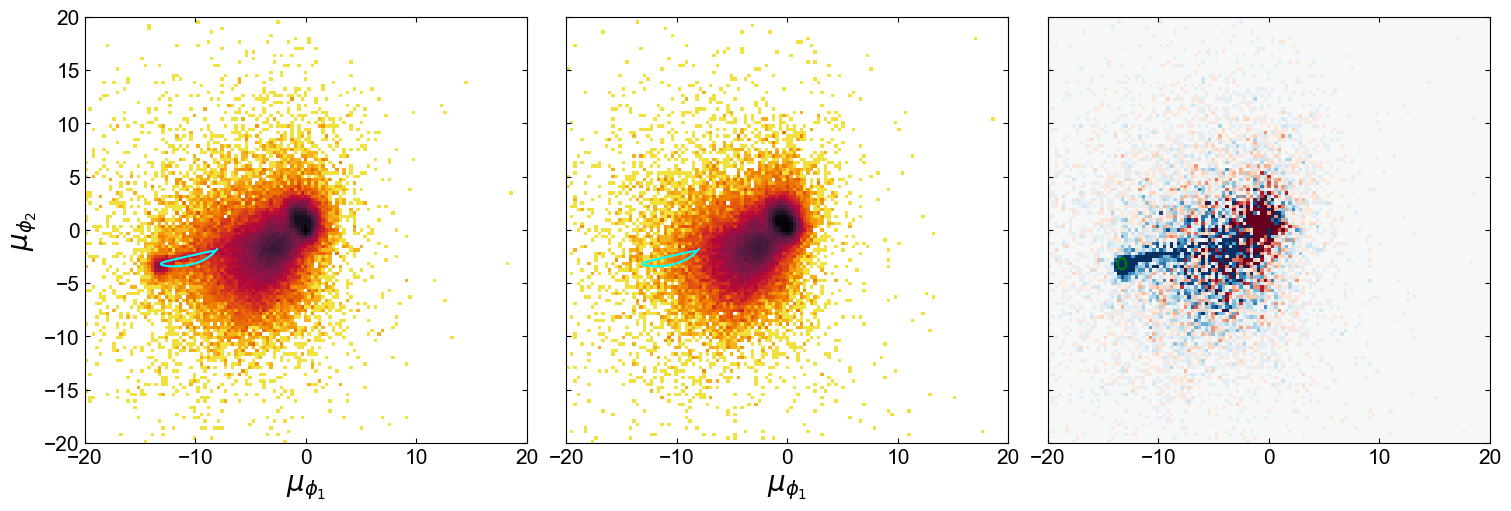

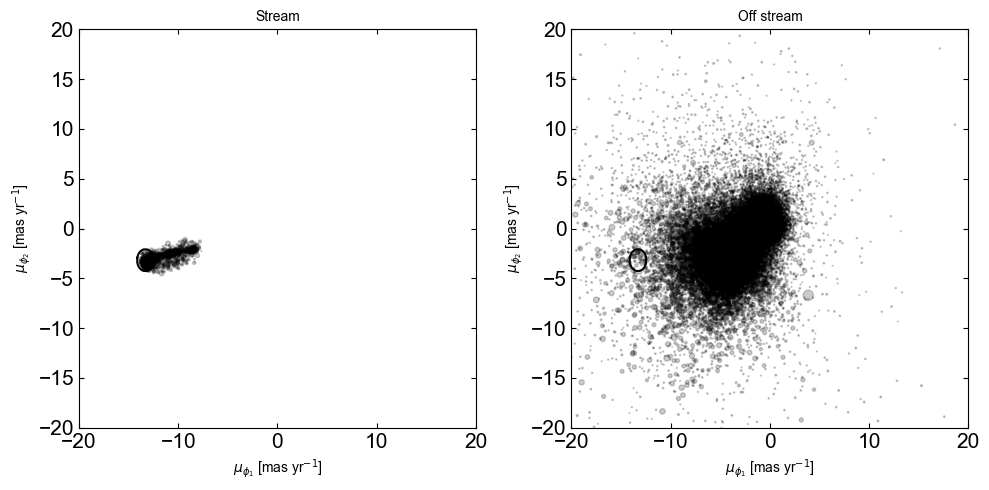

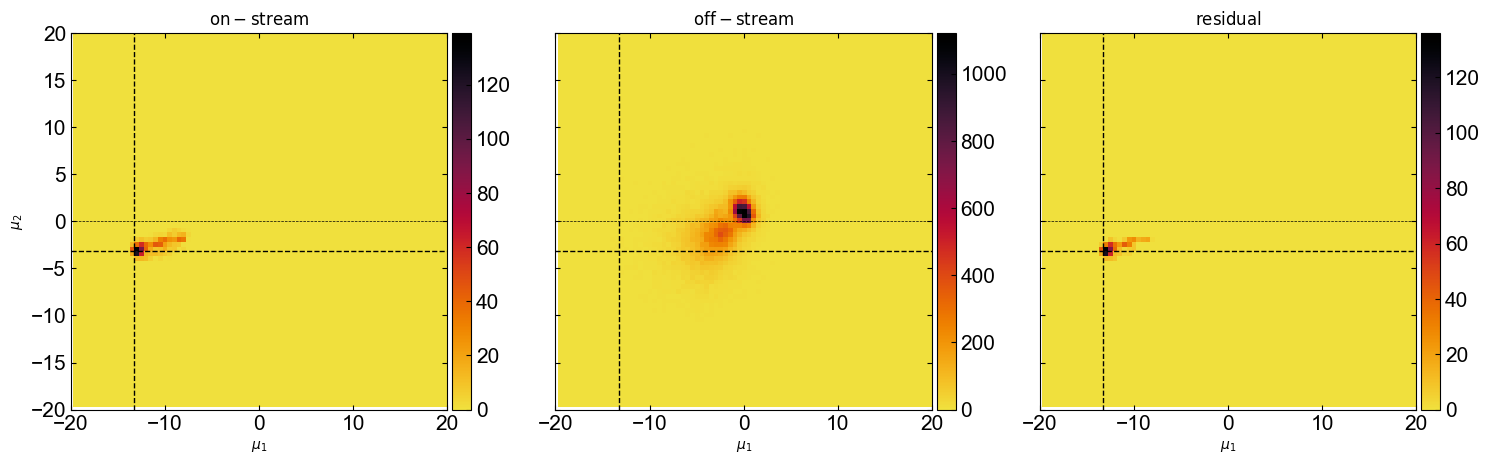

In [6]:
pmsel = ProperMotionSelection(stream, cat, pprint,
                              n_dispersion_phi1=3, n_dispersion_phi2=3, cutoff=0.1)

In [7]:
# rough pm cut to start with (this comes only from the galstreams proper motion tracks)
p.pmprint, pm_mask = rough_pm_poly(p, cat, buffer=2)
p.pmprint.vertices

        Use @ instead. [gala.coordinates.greatcircle]


array([[-15.09996078,  -5.41743859],
       [-15.09996078,   0.19860289],
       [ -6.01001683,   0.19860289],
       [ -6.01001683,  -5.41743859]])

In [154]:
# GD1Base.default_grids['pm1'] = np.linspace(p.pmprint.vertices[0,0], p.pmprint.vertices[-1,0], 100)
# GD1Base.default_grids['pm2'] = np.linspace(p.pmprint.vertices[0,1], p.pmprint.vertices[1,1], 100)
# GD1Base.default_grids['phi2'] = np.linspace(np.min(cat['phi2']),np.max(cat['phi2']), 100)

# GD1Base.coord_bounds['pm1'] = (np.min(p.pmprint.vertices[:,0]), np.max(p.pmprint.vertices[:,0]))
# GD1Base.coord_bounds['pm2'] = (np.min(p.pmprint.vertices[:,1]), np.max(p.pmprint.vertices[:,1]))
# GD1Base.coord_bounds['phi2'] = (np.min(cat['phi2']),np.max(cat['phi2']))



# GD1BackgroundModel.default_grids['pm1'] = np.linspace(p.pmprint.vertices[0,0], p.pmprint.vertices[-1,0], 100)
# GD1BackgroundModel.default_grids['pm2'] = np.linspace(p.pmprint.vertices[0,1], p.pmprint.vertices[1,1], 100)
# GD1BackgroundModel.default_grids['phi2'] = np.linspace(np.min(cat['phi2']),np.max(cat['phi2']), 100)

# GD1BackgroundModel.coord_bounds['pm1'] = (np.min(p.pmprint.vertices[:,0]), np.max(p.pmprint.vertices[:,0]))
# GD1BackgroundModel.coord_bounds['pm2'] = (np.min(p.pmprint.vertices[:,1]), np.max(p.pmprint.vertices[:,1]))
# GD1BackgroundModel.coord_bounds['phi2'] = (np.min(cat['phi2']),np.max(cat['phi2']))

# GD1StreamModel.default_grids['pm1'] = np.linspace(p.pmprint.vertices[0,0], p.pmprint.vertices[-1,0], 100)
# GD1StreamModel.default_grids['pm2'] = np.linspace(p.pmprint.vertices[0,1], p.pmprint.vertices[1,1], 100)

In [8]:
GD1Base.coord_bounds

{'phi1': (-100, 20), 'phi2': (-8, 3.3), 'pm1': (-15, -6.0), 'pm2': (-5.4, 0.2)}

In [9]:
run_data_ = o.cat[pm_mask & (iso_mask | hb_mask)]
#run_data_ = o.cat[(iso_mask | hb_mask)]
run_data = {k: np.array(run_data_[k], dtype="f8") for k in run_data_.colnames}


bkg_data_ = o.cat[pm_mask & (iso_mask | hb_mask) & ~o.on_skymask]
#bkg_data_ = o.cat[~o.on_skymask]
bkg_data = {k: np.array(bkg_data_[k], dtype="f8") for k in bkg_data_.colnames}

In [10]:
len(bkg_data['phi1'])

36459

In [11]:
# run_data = {k: np.array(data[k], dtype="f8") for k in data.colnames}
# bkg_data = {k: np.array(data[~masks['sky_track']][k], dtype="f8") for k in data.colnames}
# len(bkg_data['phi1'])

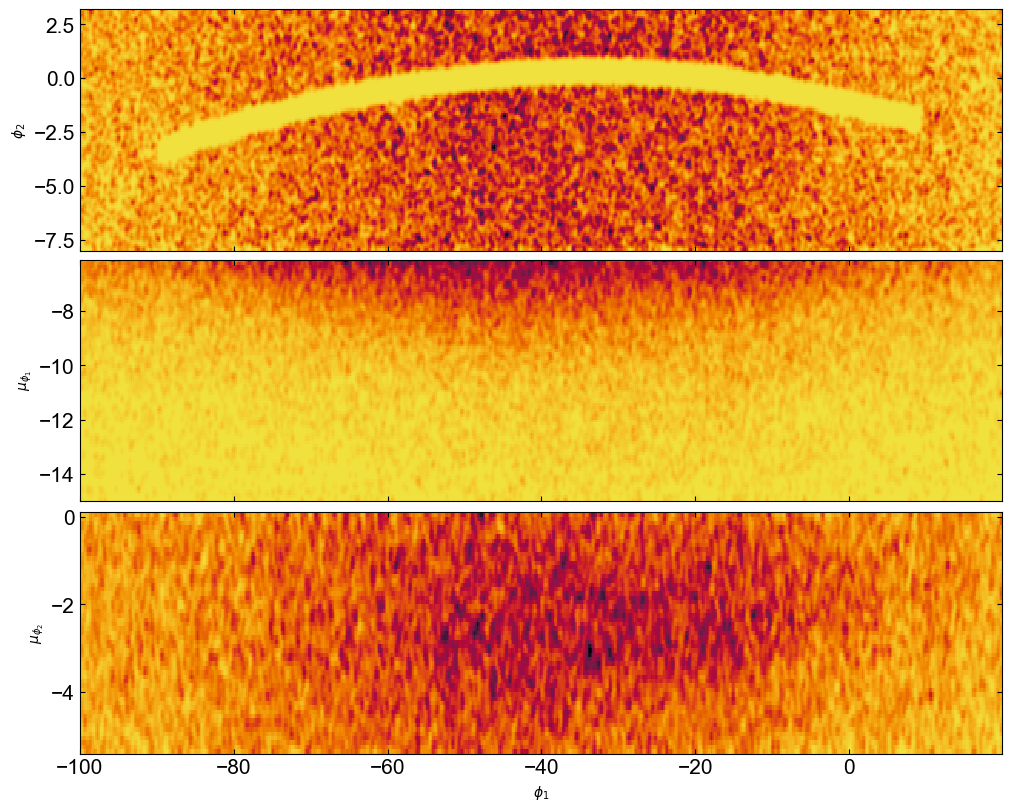

In [12]:
plot_data_projections(data=bkg_data, grids=GD1Base.default_grids,
                      smooth=1);

# Background

In [39]:
bkg_init_p = {
    "ln_N": np.log(len(bkg_data['phi1'])),
    #"phi1": {'zs': np.array([-3.5, -2.5, -1.5, -0.5, 0.5, 1.5, 2.5, 3.5])+1},
    "phi1": {'zs': np.zeros(GD1BackgroundModel.phi1_locs.shape[0]-1)},
    "phi2": {},
    "pm1": {
        "w": np.full_like(GD1BackgroundModel.pm1_knots, 0.5),
        "mean1": np.full_like(GD1BackgroundModel.pm1_knots, 0),
        "ln_std1": np.full_like(GD1BackgroundModel.pm1_knots, 1),
        "mean2": np.full_like(GD1BackgroundModel.pm1_knots, 5),
        "ln_std2": np.full_like(GD1BackgroundModel.pm1_knots, 2)
    },
    "pm2": {
        "w": np.full_like(GD1BackgroundModel.pm2_knots, 0.5),
        "mean1": np.full_like(GD1BackgroundModel.pm2_knots, -2.),
        "ln_std1": np.full_like(GD1BackgroundModel.pm2_knots, 1),
        "mean2": np.full_like(GD1BackgroundModel.pm2_knots, -3),
        "ln_std2": np.full_like(GD1BackgroundModel.pm2_knots, 2)
    },
}
background_init = GD1BackgroundModel(bkg_init_p)

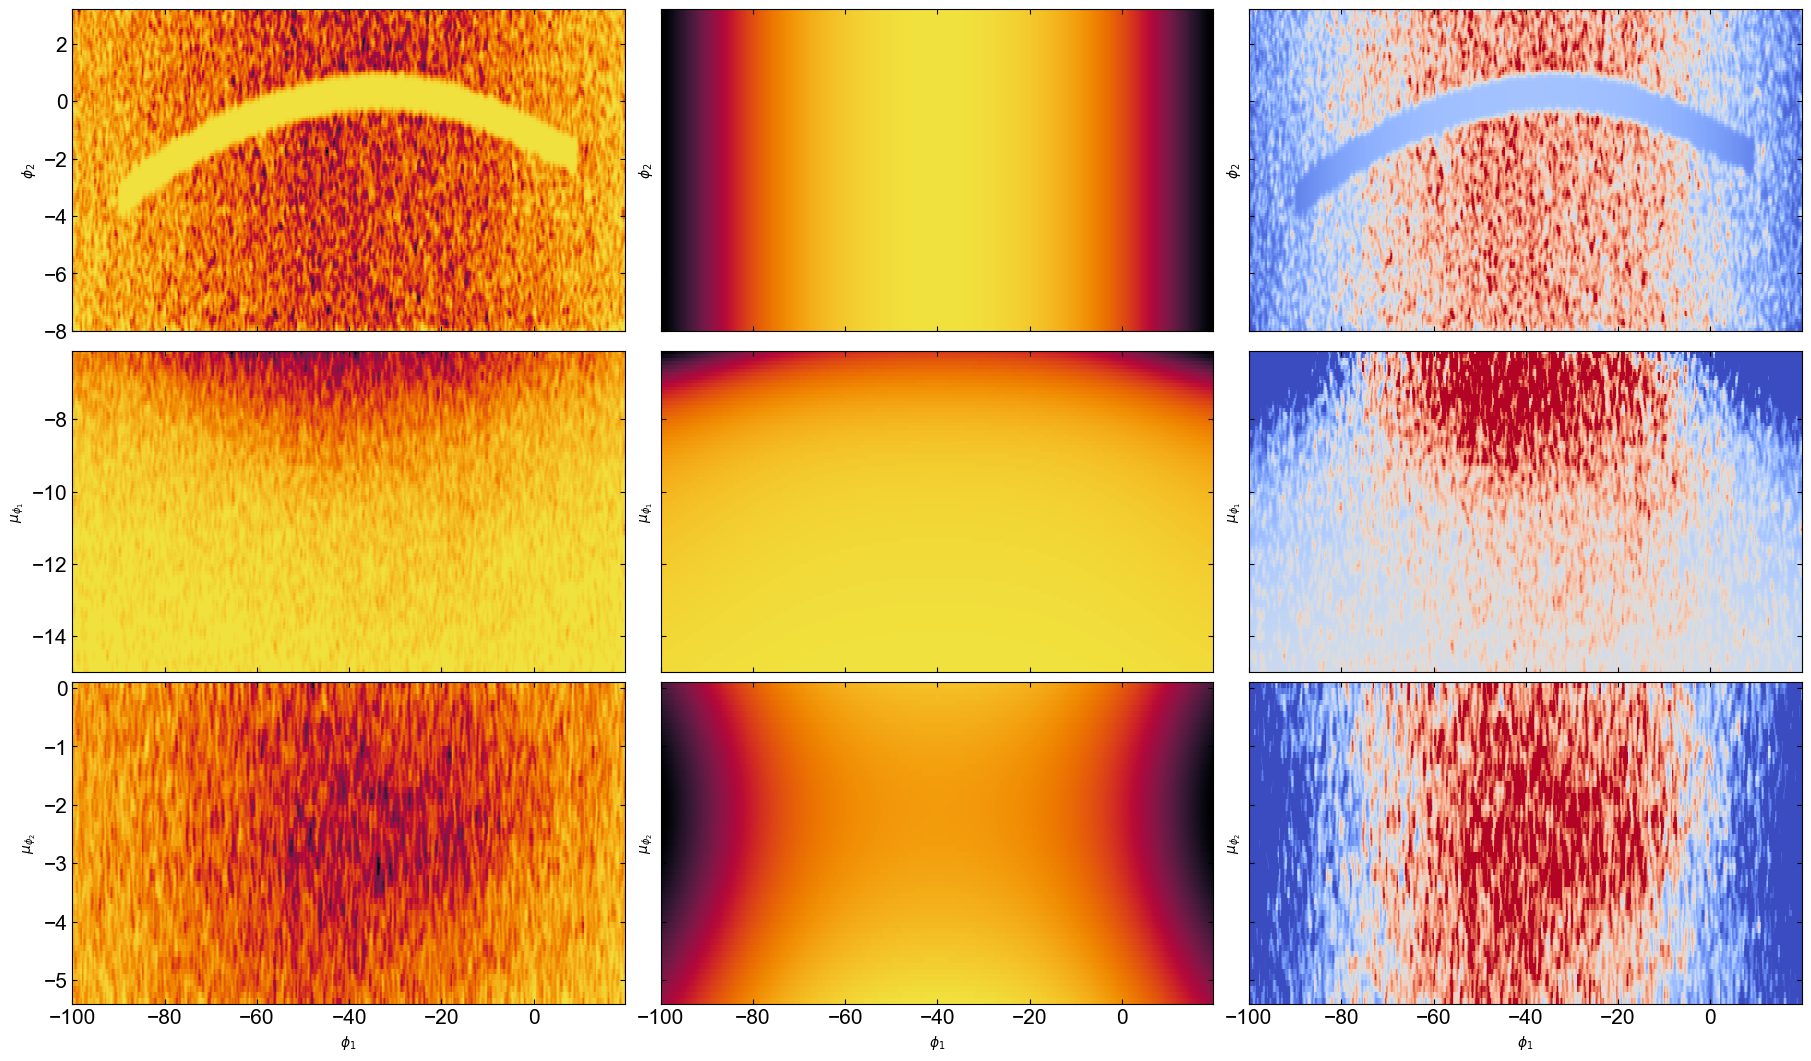

In [40]:
fig, axes = plt.subplots(
    len(background_init.coord_names) - 1,
    3,
    figsize=(18, 3.5 * (len(background_init.coord_names) - 1)),
    sharex=True,
    sharey="row",
    constrained_layout=True,
)

axes = np.atleast_2d(axes)
plot_data_projections(
    data=bkg_data,
    grids=GD1BackgroundModel.default_grids,
    axes=axes[:, 0],
    # coord_names=GD1BackgroundModel.coord_names,
)
background_init.plot_model_projections(axes=axes[:, 1])
background_init.plot_residual_projections(
    data=bkg_data, axes=axes[:, 2], pcolormesh_kwargs=dict(vmin=-1, vmax=1)
)

for ax in axes[-1]:
    ax.set_xlabel(r"$\phi_1$")

In [41]:
background_init.coord_bounds

{'phi1': (-100, 20), 'phi2': (-8, 3.3), 'pm1': (-15, -6.0), 'pm2': (-5.4, 0.2)}

In [42]:
background_init.default_grids['pm1'].max()

-6.100000000000032

In [43]:
background_init.variables['pm2'].coord_bounds

(-5.4, 0.2)

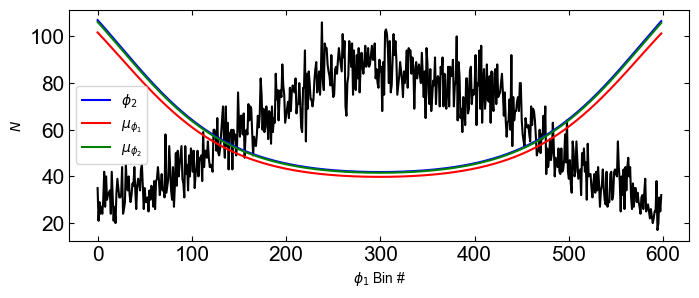

In [44]:
H_data1, *_ = np.histogram2d(
    bkg_data["phi1"],
    bkg_data["phi2"],
    bins=(background_init.default_grids["phi1"], background_init.default_grids['phi2'])
)

grids, ln_ns = background_init.evaluate_on_2d_grids()

fig, ax1 = plt.subplots(1,1,figsize=(8, 3))
ax1.plot(H_data1.sum(axis=1), c='k')
ax1.plot(np.exp(ln_ns[('phi1', 'phi2')]).sum(axis=0), c='b', label=r'$\phi_2$')
ax1.plot(np.exp(ln_ns[('phi1', 'pm1')]).sum(axis=0), c='r', label=r'$\mu_{\phi_1}$')
ax1.plot(np.exp(ln_ns[('phi1', 'pm2')]).sum(axis=0), c='g', label=r'$\mu_{\phi_2}$')
ax1.set_xlabel(r'$\phi_1$ Bin #')
ax1.set_ylabel(r'$N$')
ax1.legend()
plt.show()

In [45]:
def optimize(cls, data, init_params, jaxopt_kwargs=None, use_bounds=True, **kwargs):
    """
    A wrapper around numpyro_ext.optim utilities, which enable jaxopt optimization
    for numpyro models.
    """
    import jaxopt

    if jaxopt_kwargs is None:
        jaxopt_kwargs = {}
    jaxopt_kwargs.setdefault("maxiter", 1024)  # TODO: TOTALLY ARBITRARY

    optimize_kwargs = kwargs
    #jaxopt_kwargs.setdefault("method", "L-BFGS-B")
    optimize_kwargs["bounds"] = cls._get_jaxopt_bounds()
    optimize_kwargs["bounds"] = (
        cls._normalize_variable_keys(optimize_kwargs["bounds"][0]),
        cls._normalize_variable_keys(optimize_kwargs["bounds"][1]),
    )
    Optimizer = jaxopt.LBFGSB

    optimizer = Optimizer(**jaxopt_kwargs, fun=cls._objective)
    opt_res = optimizer.run(
        init_params=cls._normalize_variable_keys(init_params),
        data=cls._normalize_variable_keys(data),
        **optimize_kwargs,
    )
    return cls._expand_variable_keys(opt_res.params), opt_res.state

In [46]:
bkg_opt_pars, bkg_info = optimize(GD1BackgroundModel,
    data=bkg_data,
    init_params=bkg_init_p,
    use_bounds=True,
    jaxopt_kwargs=dict(maxiter=4096),
)
background_opt = GD1BackgroundModel(bkg_opt_pars)
bkg_info

LbfgsbState(iter_num=Array(14, dtype=int64, weak_type=True), value=Array(1.09638182, dtype=float64), grad={'ln_N': Array(-0.00040953, dtype=float64), 'phi1': {'zs': Array([-4.37024759e-06,  1.09852116e-08, -9.78273968e-05, -2.94829822e-04,
        4.80328072e-04,  1.87090511e-04, -8.64022603e-05, -4.25631531e-05],      dtype=float64)}, 'phi2': {}, 'pm1': {'ln_std1': Array([ 4.36633371e-05,  2.80032291e-04, -9.42825418e-07,  1.55380700e-04,
       -1.65833279e-04, -5.60112426e-04, -2.67659619e-04,  1.61173692e-04,
        1.48374159e-04,  2.14522456e-04,  2.58683708e-04,  1.82293818e-04,
        1.71445194e-05], dtype=float64), 'ln_std2': Array([-2.18004861e-05, -2.61830235e-04, -1.35864961e-04, -1.43780512e-04,
       -2.39660561e-04, -5.89476261e-04, -3.35796815e-04, -6.21072093e-05,
        1.75291261e-05, -9.93212113e-05, -2.19765871e-04, -1.61136059e-04,
        2.32188849e-04], dtype=float64), 'mean1': Array([-3.24343517e-06, -2.47363526e-05, -2.75648505e-06, -9.85763850e-06,
    

In [249]:
# bkg_opt_pars, bkg_info = GD1BackgroundModel.optimize(
#     data=bkg_data,
#     init_params=bkg_init_p,
#     use_bounds=True,
#     jaxopt_kwargs=dict(maxiter=4096),
# )
# background_opt = GD1BackgroundModel(bkg_opt_pars)
# bkg_info

In [47]:
bkg_opt_pars

{'ln_N': Array(10.50353401, dtype=float64),
 'phi1': {'zs': Array([-1.95315087, -1.62286281, -0.75978769,  0.54990282,  1.10689354,
          2.06525563,  1.24493317,  0.40482997], dtype=float64)},
 'phi2': {},
 'pm1': {'ln_std1': Array([1.10520797, 1.15241428, 1.11691237, 1.19048374, 1.2229245 ,
         1.33781756, 1.32024059, 1.25720708, 1.18939558, 1.19736708,
         1.1847248 , 1.12286372, 1.18424669], dtype=float64),
  'ln_std2': Array([1.96311723, 1.8805559 , 2.01568399, 1.85668754, 1.97535964,
         1.91994697, 2.06063802, 2.01019916, 1.96307677, 1.94053903,
         1.8904773 , 1.97918745, 1.91463038], dtype=float64),
  'mean1': Array([-0.00775696, -0.01093583, -0.0082137 , -0.01679358, -0.02402514,
         -0.03611998, -0.03338707, -0.02413031, -0.01308704, -0.01434483,
         -0.01362669, -0.00718405, -0.01340903], dtype=float64),
  'mean2': Array([5.00125201, 5.00471908, 4.99971346, 5.00565031, 5.0020413 ,
         5.00354944, 4.99920079, 5.00041098, 4.99978156, 5.0

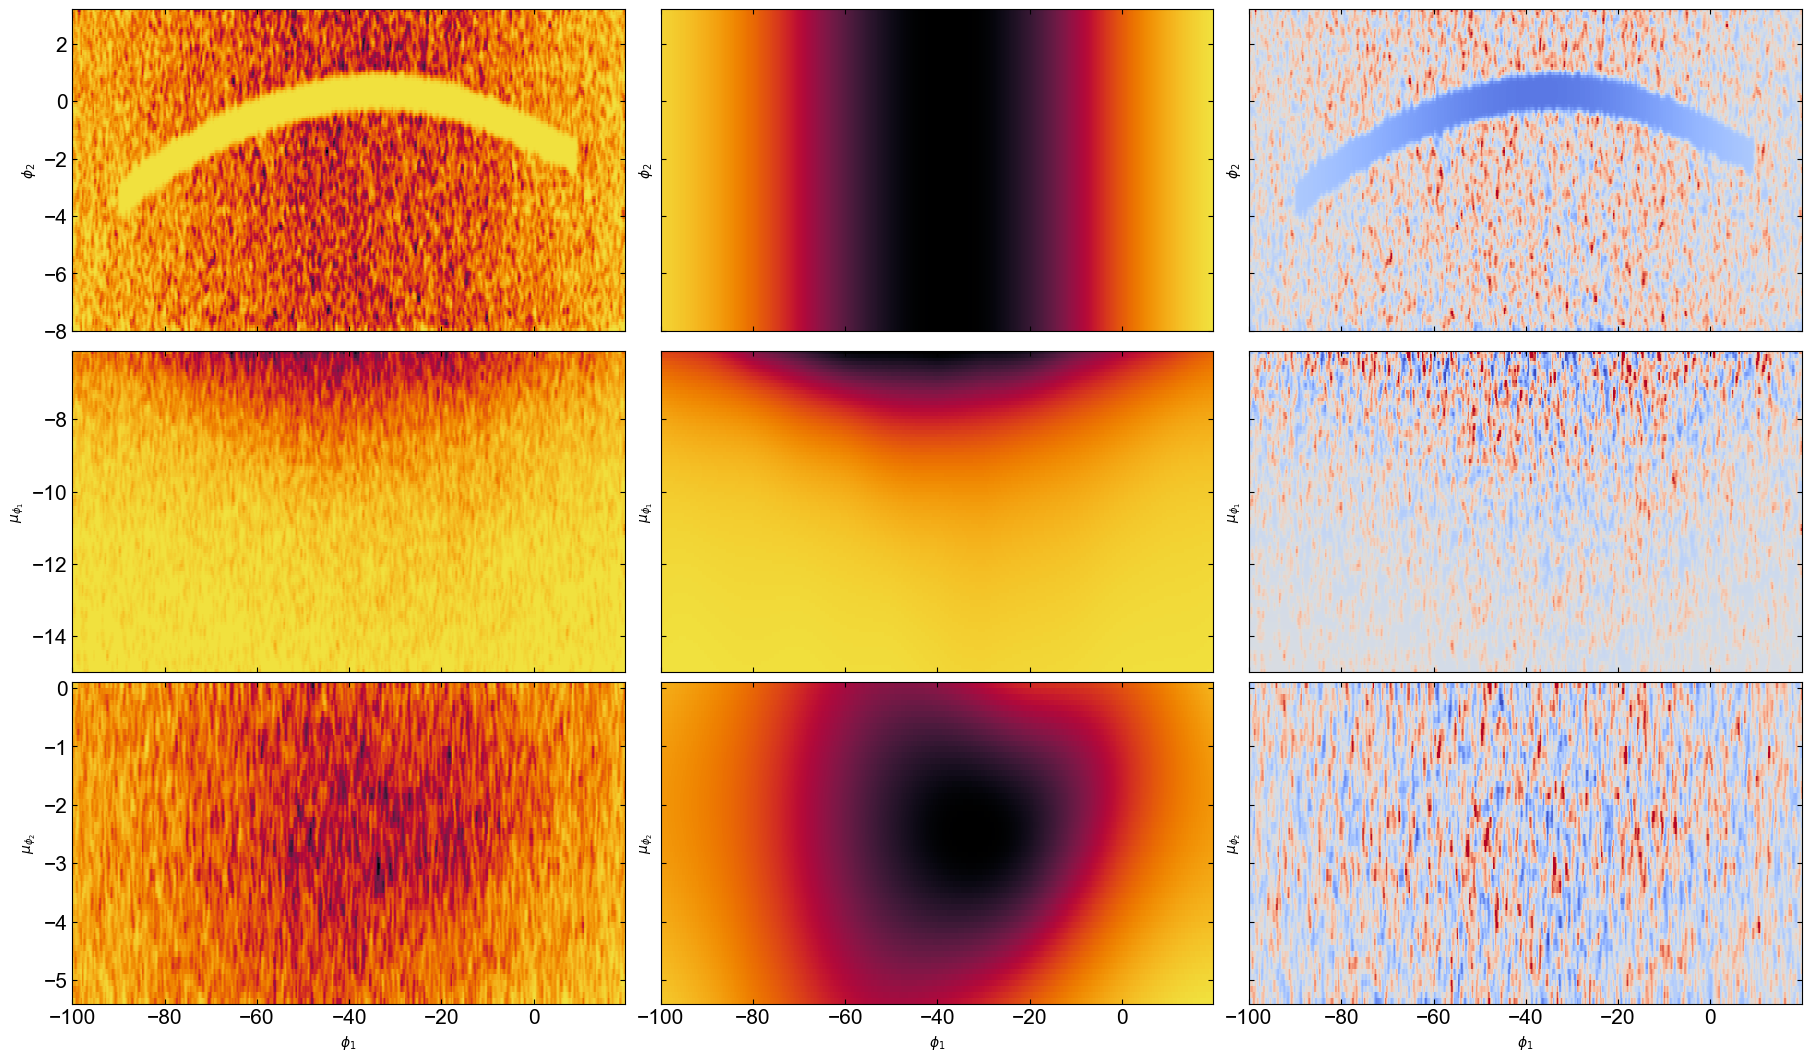

In [49]:
fig, axes = plt.subplots(
    len(background_opt.coord_names) - 1,
    3,
    figsize=(18, 3.5 * (len(background_opt.coord_names) - 1)),
    sharex=True,
    sharey="row",
    constrained_layout=True,
)

axes = np.atleast_2d(axes)
plot_data_projections(
    data=bkg_data,
    grids=GD1BackgroundModel.default_grids,
    axes=axes[:, 0],
    # coord_names=GD1BackgroundModel.coord_names,
)
background_opt.plot_model_projections(axes=axes[:, 1])
background_opt.plot_residual_projections(
    data=bkg_data, axes=axes[:, 2], pcolormesh_kwargs=dict(vmin=-1, vmax=1)
)

for ax in axes[-1]:
    ax.set_xlabel(r"$\phi_1$")
fig.savefig('test_residual.png')

# Stream

In [50]:
# TODO: replace this with galstreams initialization
from scipy.stats import binned_statistic
from scipy.interpolate import InterpolatedUnivariateSpline

#stream_mask = masks["sky_track"] & masks["pm_rough"]
stream_data_ = o.cat[pmsel.pm12_mask & (iso_mask | hb_mask) & o.on_skymask]
#stream_data = {k: v[stream_mask] for k, v in stream_data_.items()}
stream_data = {k: np.array(stream_data_[k], dtype="f8") for k in stream_data_.colnames}

_phi2_stat = binned_statistic(stream_data["phi1"], stream_data["phi2"], bins=np.linspace(-90, 10, 21))
_phi2_interp = InterpolatedUnivariateSpline(
    0.5 * (_phi2_stat.bin_edges[:-1] + _phi2_stat.bin_edges[1:]), _phi2_stat.statistic
)

_pm1_stat = binned_statistic(stream_data["phi1"], stream_data["pm1"], bins=np.linspace(-80, 0, 32))
_pm1_interp = InterpolatedUnivariateSpline(
    0.5 * (_pm1_stat.bin_edges[:-1] + _pm1_stat.bin_edges[1:]), _pm1_stat.statistic, ext=3
)

_pm2_stat = binned_statistic(stream_data["phi1"], stream_data["pm2"], bins=np.linspace(-80, 0, 32))
_pm2_interp = InterpolatedUnivariateSpline(
    0.5 * (_pm2_stat.bin_edges[:-1] + _pm2_stat.bin_edges[1:]), _pm2_stat.statistic, ext=3
)

In [51]:
_pm1_interp=InterpolatedUnivariateSpline(p.track.track.transform_to(p.track.stream_frame).phi1,
                                         p.track.track.transform_to(p.track.stream_frame).pm_phi1_cosphi2,
                                         ext=3)
_pm2_interp=InterpolatedUnivariateSpline(p.track.track.transform_to(p.track.stream_frame).phi1,
                                         p.track.track.transform_to(p.track.stream_frame).pm_phi2,
                                         ext=3)

        Use @ instead. [gala.coordinates.greatcircle]


In [53]:
stream_init_p = {
    "ln_N": np.log(len(stream_data['phi1'])),
    "phi1": {
        "zs": np.zeros(GD1StreamModel.phi1_locs.shape[0]-1)
    },
    "phi2": {
        "mean": _phi2_interp(GD1StreamModel.phi2_knots),
        "ln_std": np.full_like(GD1StreamModel.phi2_knots, -0.5)
    },
    "pm1": {
        "mean": _pm1_interp(GD1StreamModel.pm1_knots),
        "ln_std": np.full_like(GD1StreamModel.pm1_knots, -1)
    },
    "pm2": {
        "mean": _pm2_interp(GD1StreamModel.pm2_knots),
        "ln_std": np.full_like(GD1StreamModel.pm2_knots, -1)
    }
}

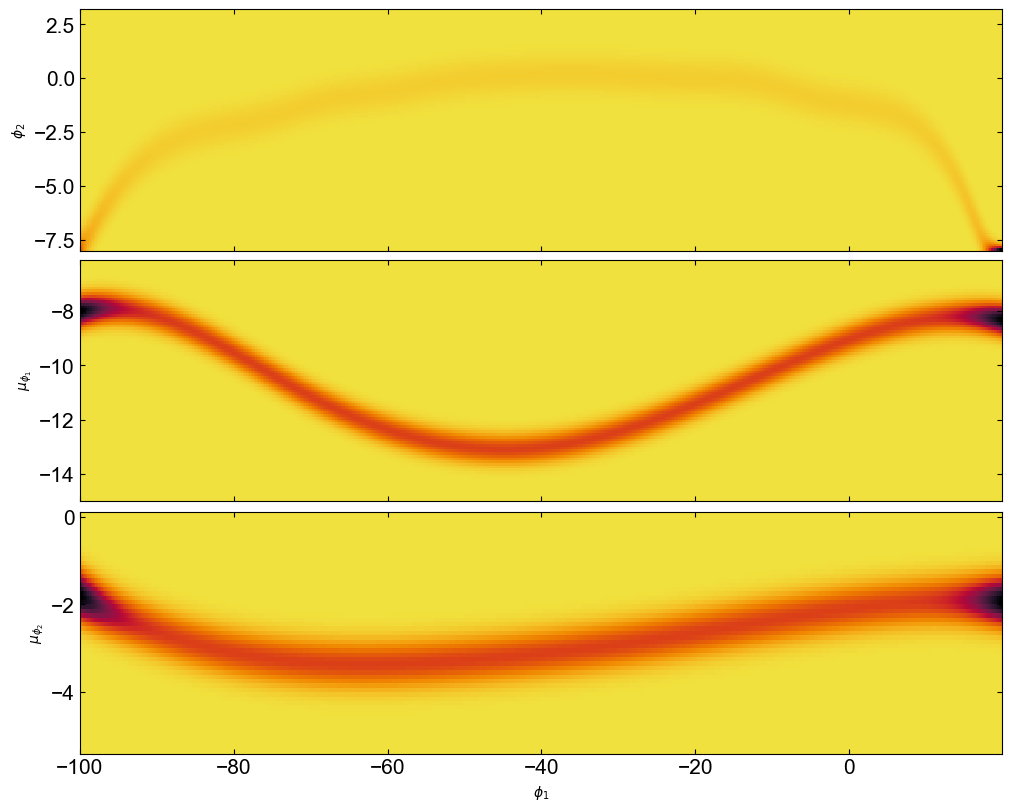

In [54]:
stream_init = GD1StreamModel(stream_init_p)
_ = stream_init.plot_model_projections()

In [55]:
stream_init_p

{'ln_N': 7.213768308118642,
 'phi1': {'zs': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])},
 'phi2': {'mean': array([-8.24173489e+00, -3.94275802e+00, -2.45380431e+00, -1.86048384e+00,
         -1.03345998e+00, -6.09293288e-01, -1.24647276e-01,  1.07382554e-01,
          1.90458011e-01,  1.01875713e-01, -1.09002124e-02, -2.10482931e-01,
         -9.78888085e-01, -1.46285208e+00, -3.47866928e+00, -1.11767560e+01]),
  'ln_std': array([-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5,
         -0.5, -0.5, -0.5, -0.5, -0.5])},
 'pm1': {'mean': array([ -8.01001683,  -8.77103682, -11.15172534, -12.76884806,
         -13.02597314, -11.97714148, -10.18789348,  -8.59629564,
          -8.319378  ]),
  'ln_std': array([-1., -1., -1., -1., -1., -1., -1., -1., -1.])},
 'pm2': {'mean': array([-1.80139711, -3.24562547, -3.27612746, -2.78970843, -2.09902309,
         -1.99723637]),
  'ln_

In [56]:
stream_opt_pars, info = GD1StreamModel.optimize(
    data=stream_data, init_params=stream_init_p, use_bounds=True
)
stream_opt = GD1StreamModel(stream_opt_pars)
info

ScipyMinimizeInfo(fun_val=Array(-0.99552015, dtype=float64, weak_type=True), success=True, status=0, iter_num=855, hess_inv=LbfgsInvHessProduct(sk=[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  4.33705568e-05 -1.42642547e-04
  -2.97073651e-04  3.58614317e-04 -3.81244333e-04 -2.91619637e-04
  -2.11773142e-04  5.05842624e-04 -4.72543424e-04  1.25051550e-04
  -1.81415931e-04 -6.87446530e-05 -1.46485322e-04 -1.12400221e-04
   9.73484161e-06 -3.83288304e-04 -4.12422360e-04  7.55294718e-05
   3.91637481e-05 -4.51161171e-04  4.61346143e-05  0.00000000e+00
   3.54505434e-04  1.00655960e-04  2.72715182e-05  5.59229783e-06
   6.55561654e-07 -1.54526802e-04 -3.53421444e-05  1.58845878e-05
   4.58238223e-05  5.57330820e-06  4.99884212e-05  6.97611274e-06
  -1.16845152e-06 -2.36099380e-05  1.42739886e-05 -3.59747479e-05
   2.88410169e-06 -9.93749268e-06 -2.44076433e-05  2.45760193e-06
   5.23577365e-05 -2.41442573e-05  9.43354033e-05 -3.64537163

Text(0, 0.5, '$\\phi_2$')

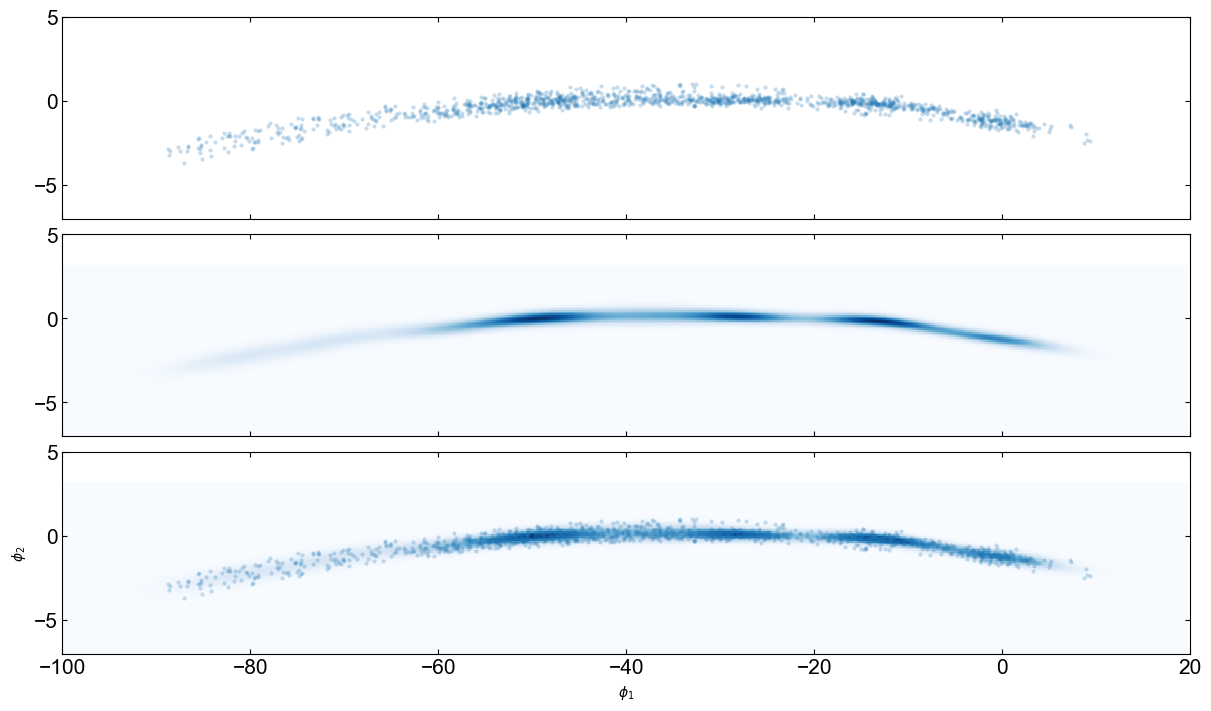

In [57]:
# _grids, ln_dens = GD1StreamModel(stream_init_p).evaluate_on_2d_grids()
_grids, ln_dens = stream_opt.evaluate_on_2d_grids()

fig, axes = plt.subplots(3, 1, figsize=(12, 7), constrained_layout=True, sharex=True, sharey=True)

for ax in [axes[0], axes[2]]:
    ax.plot(
        stream_data['phi1'],
        stream_data['phi2'],
        marker="o",
        markeredgewidth=0,
        markersize=3.0,
        ls="none",
        alpha=0.25,
    )
    
for ax in [axes[1], axes[2]]:
    ax.pcolormesh(
        _grids[('phi1', 'phi2')][0],
        _grids[('phi1', 'phi2')][1],
        np.exp(ln_dens[('phi1', 'phi2')]),
        cmap="Blues",
        shading='auto'
    )
ax.set_xlim(-100, 20)
ax.set_ylim(-7, 5)

ax.set_xlabel(r"$\phi_1$")
ax.set_ylabel(r"$\phi_2$")

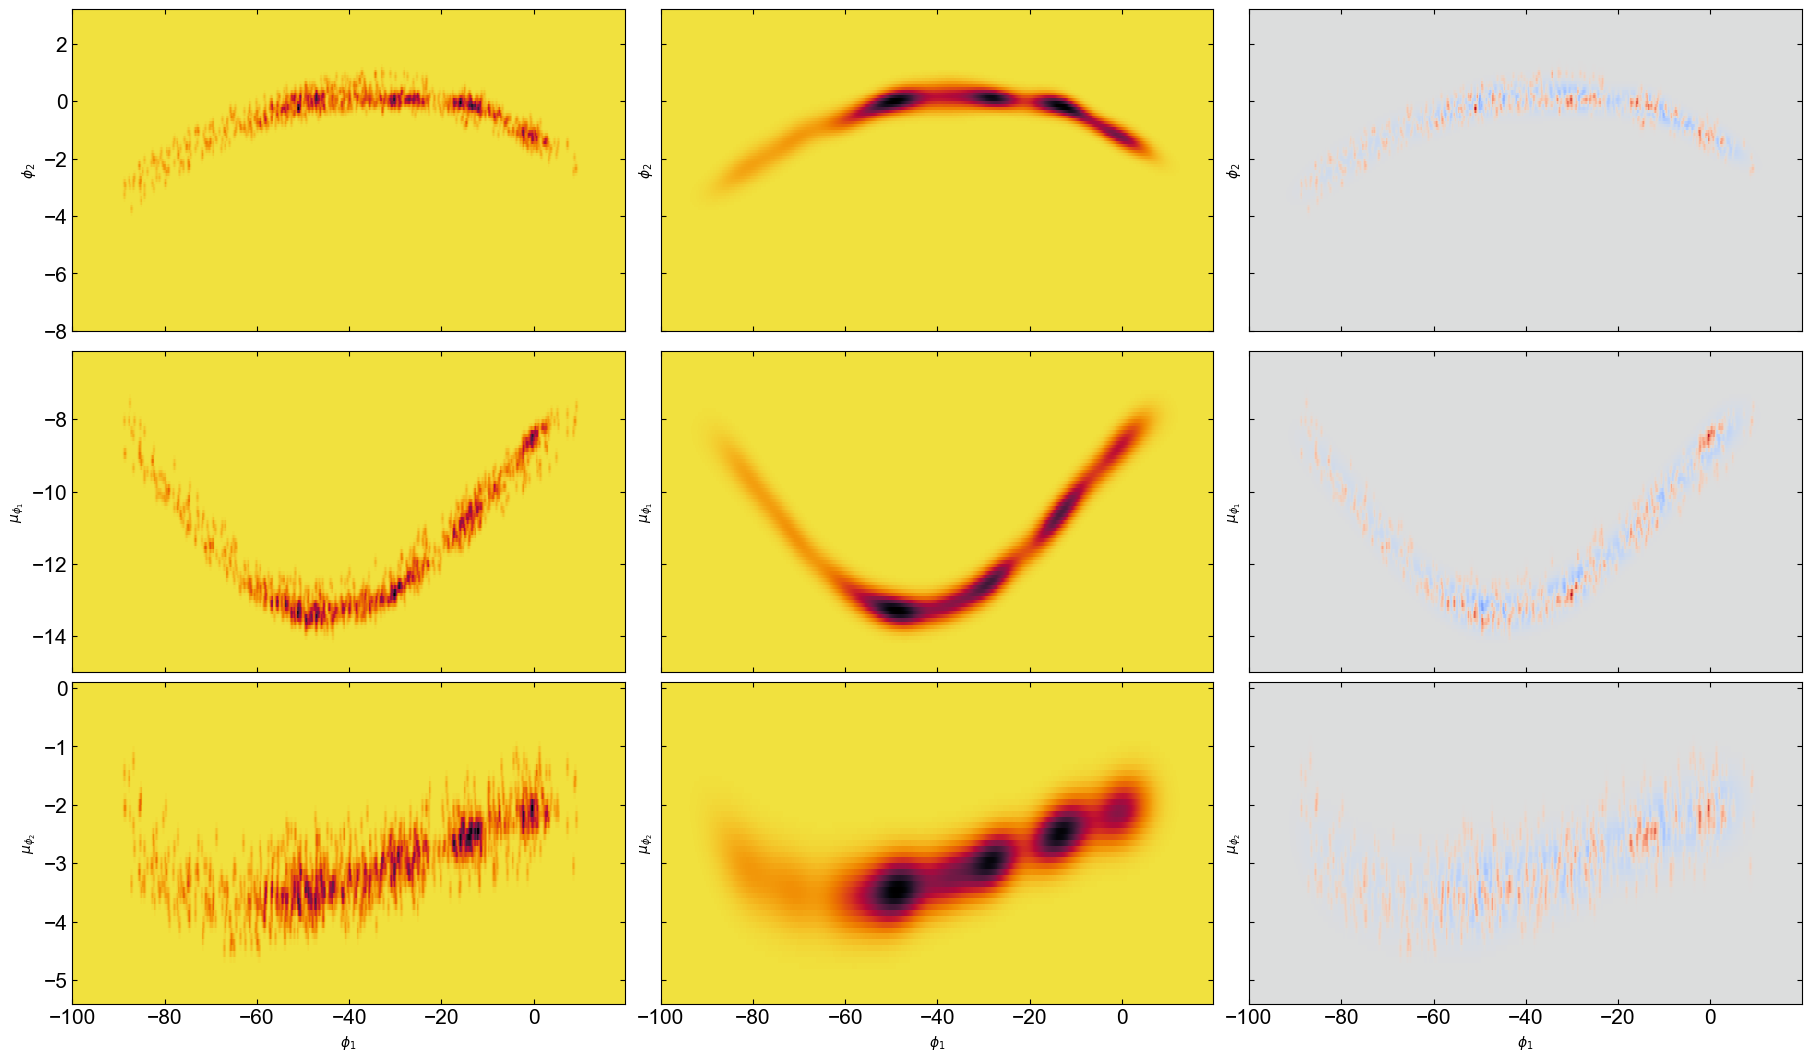

In [58]:
fig, axes = plt.subplots(
    len(background_opt.coord_names) - 1,
    3, 
    figsize=(18, 3.5 * (len(stream_opt.coord_names) - 1)),
    sharex=True,
    sharey="row",
    constrained_layout=True,
)

axes = np.atleast_2d(axes)
plot_data_projections(
    data=stream_data,
    grids=GD1Base.default_grids,
    axes=axes[:, 0],
)
stream_opt.plot_model_projections(axes=axes[:, 1])
stream_opt.plot_residual_projections(
    data=stream_data, axes=axes[:, 2], pcolormesh_kwargs=dict(vmin=-1, vmax=1)
)

for ax in axes[-1]:
    ax.set_xlabel(r"$\phi_1$")

# Mixture of Stream + Background (no off-track)

In [59]:
Components = [GD1StreamModel, GD1BackgroundModel]
mix_params0 = {"stream": stream_opt_pars, "background": bkg_opt_pars}

In [60]:
mix_init = StreamMixtureModel(mix_params0, Components)

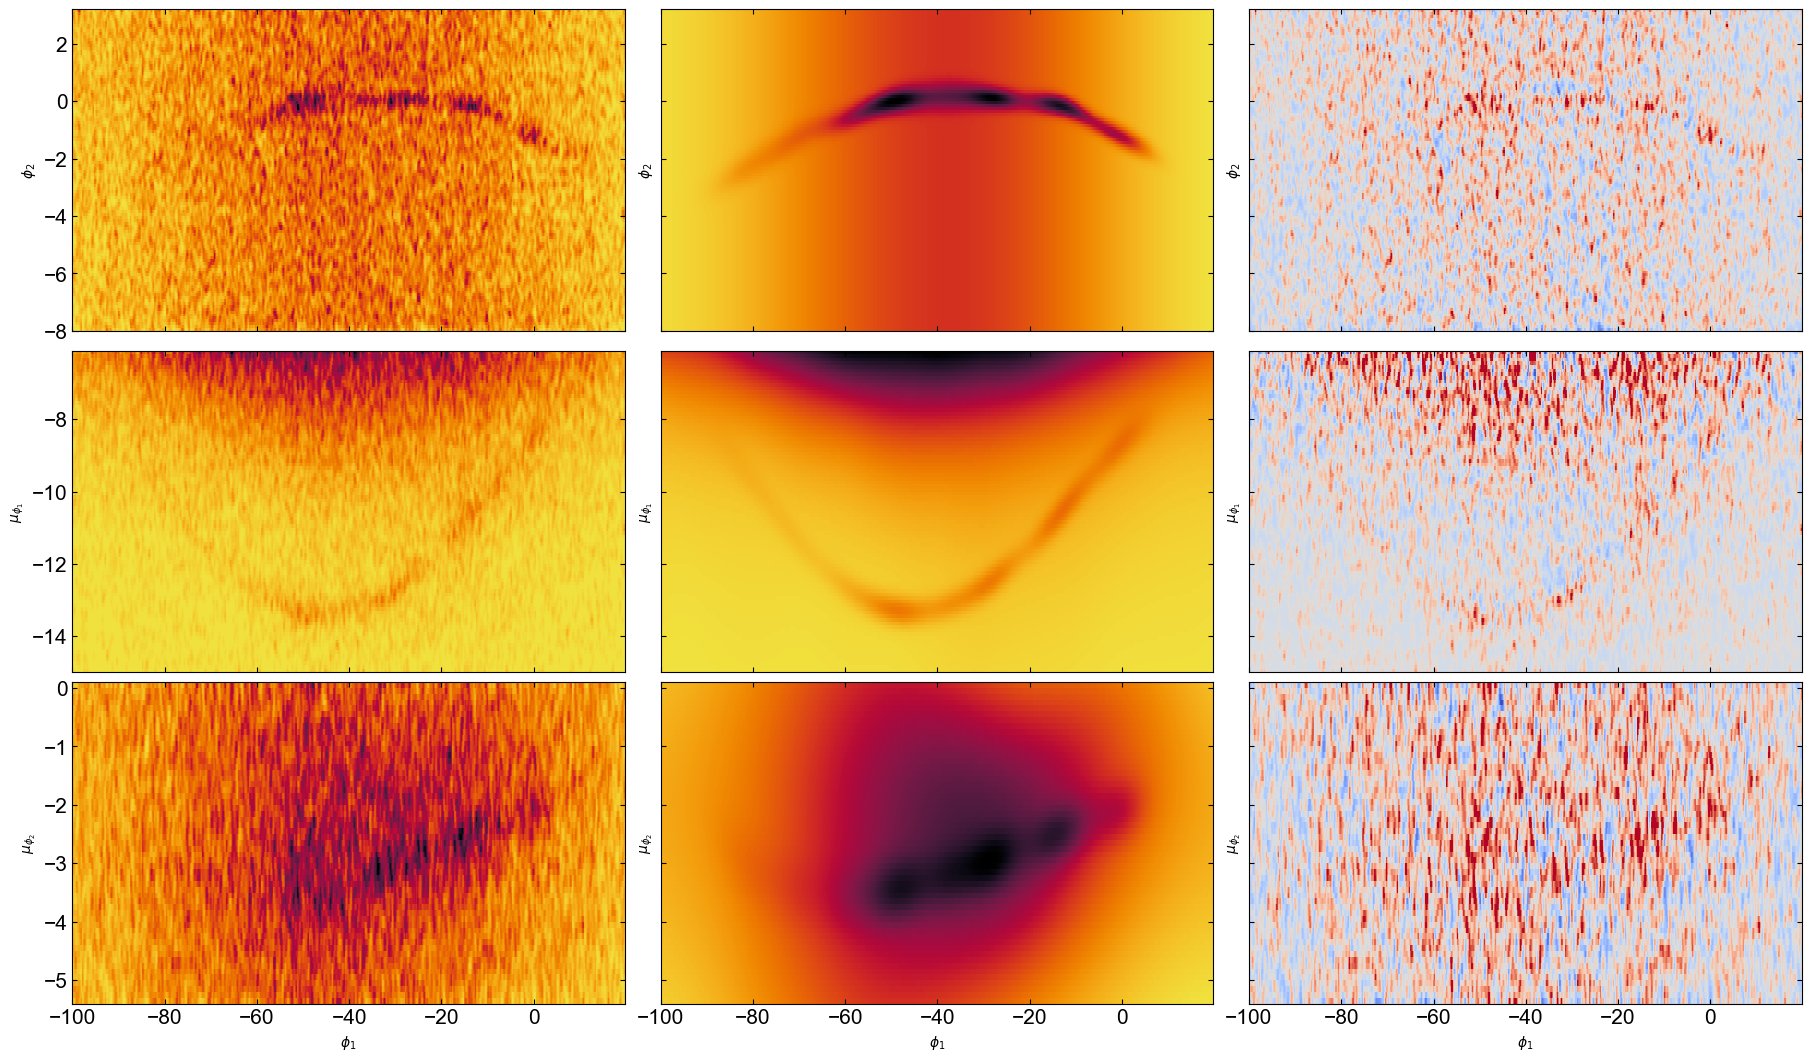

In [61]:
fig, axes = plt.subplots(
    len(stream_opt.coord_names) - 1,
    3, 
    figsize=(18, 3.5 * (len(stream_opt.coord_names) - 1)),
    sharex=True,
    sharey="row",
    constrained_layout=True,
)

axes = np.atleast_2d(axes)
plot_data_projections(
    data=run_data,
    grids=GD1Base.default_grids,
    axes=axes[:, 0],
)
mix_init.plot_model_projections(axes=axes[:, 1])
mix_init.plot_residual_projections(
    data=run_data, axes=axes[:, 2], pcolormesh_kwargs=dict(vmin=-1, vmax=1)
)

for ax in axes[-1]:
    ax.set_xlabel(r"$\phi_1$")

In [62]:
mix_opt_pars, info = StreamMixtureModel.optimize(
    data=run_data, Components=Components, init_params=mix_params0, use_bounds=True
)
mix_opt = StreamMixtureModel(mix_opt_pars, Components=Components)
info

ScipyMinimizeInfo(fun_val=Array(0.89098645, dtype=float64, weak_type=True), success=True, status=0, iter_num=1744, hess_inv=LbfgsInvHessProduct(sk=[[-2.63129857e-06  1.22465690e-05 -6.70366396e-06 ... -1.44090393e-05
   5.08415684e-05  8.29636109e-05]
 [ 1.63235310e-05  9.24327134e-06 -6.56689217e-08 ...  3.17807325e-05
  -2.79948261e-05  2.36436199e-04]
 [-5.39033669e-05  1.07276592e-05  1.21558593e-05 ...  3.39945526e-06
  -1.29753455e-05  9.06485159e-05]
 ...
 [ 1.22050510e-04  8.22663669e-06 -8.05230166e-06 ... -2.47977268e-05
   4.47395350e-05 -3.83559616e-05]
 [ 1.95645663e-05  4.46170657e-06 -5.23483504e-06 ... -9.38429431e-06
   2.37639778e-05 -5.06612653e-06]
 [ 1.98708573e-05  1.03218664e-05 -1.18404229e-05 ... -2.07892958e-05
   6.13025515e-05  3.05510302e-05]], yk=[[-1.94284419e-06  2.76511082e-09  2.00709927e-07 ... -1.02980693e-06
   2.57141475e-06  1.33428671e-07]
 [ 1.63768112e-05  7.28310782e-09  4.60732009e-07 ...  6.20443925e-07
  -1.07169273e-06 -7.70687211e-09]
 [-

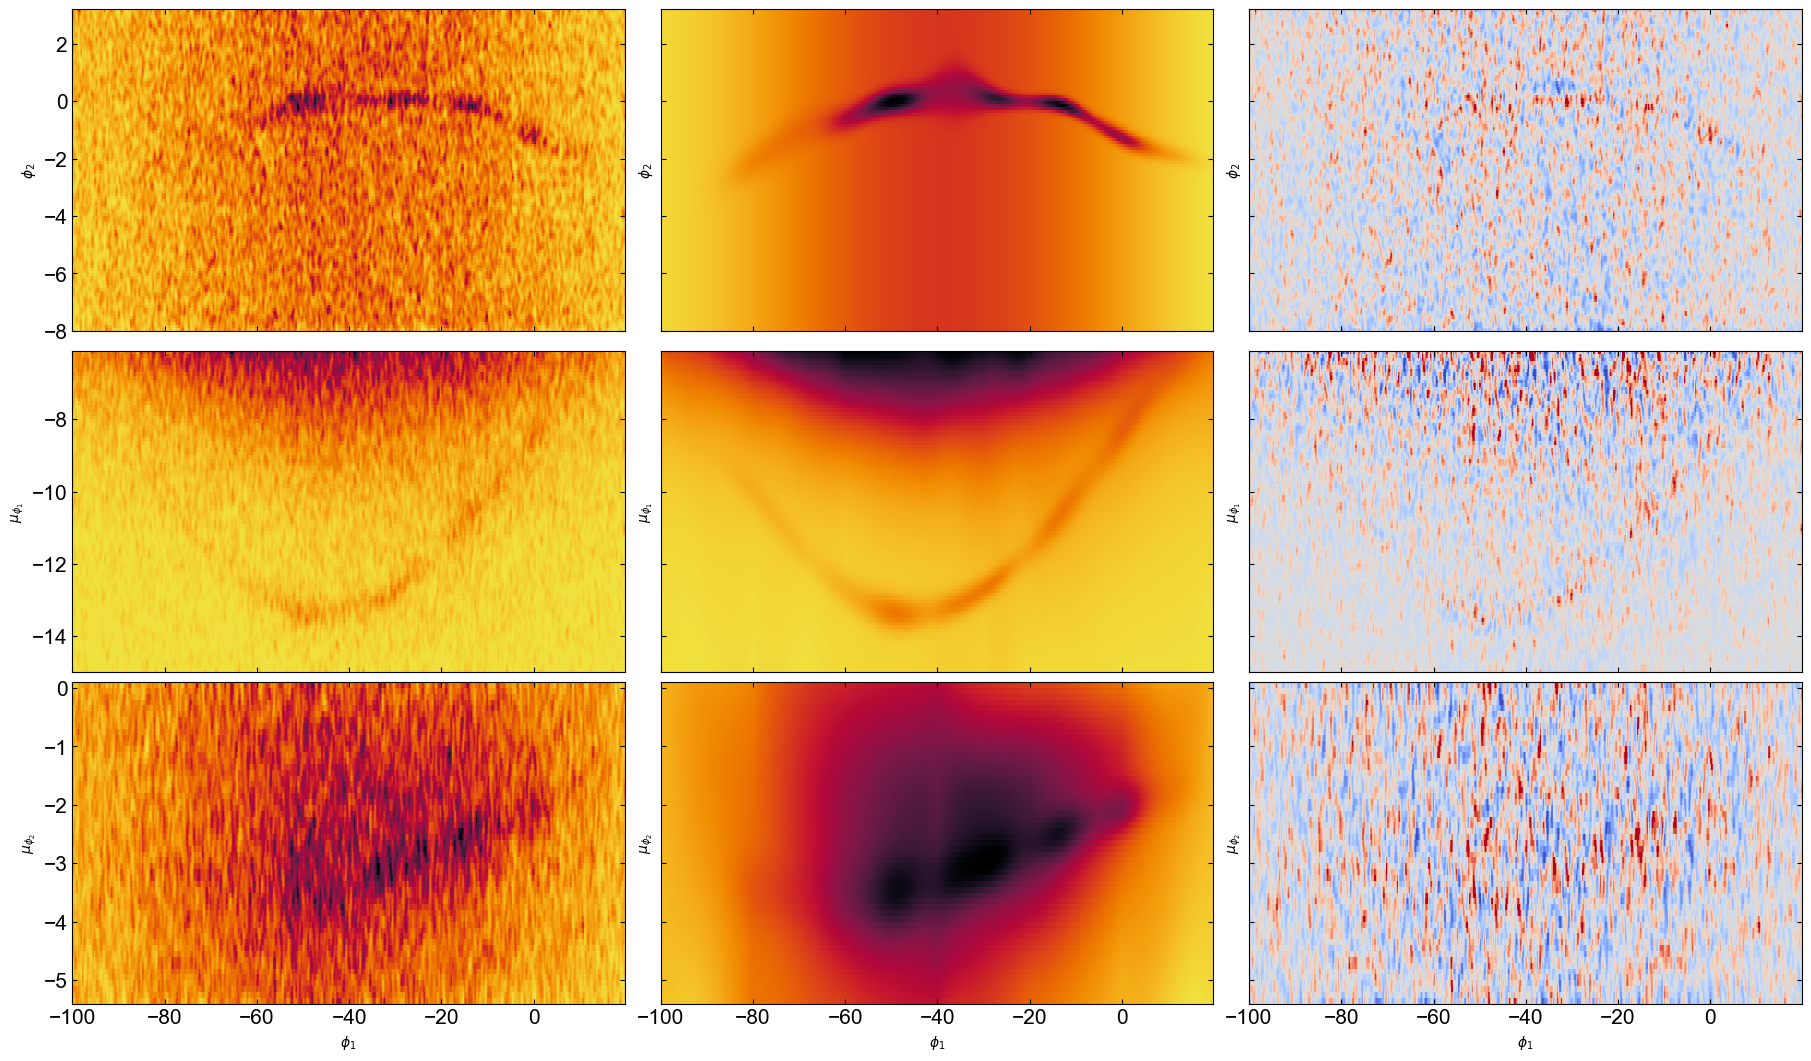

In [63]:
fig, axes = plt.subplots(
    len(stream_opt.coord_names) - 1,
    3, 
    figsize=(18, 3.5 * (len(stream_opt.coord_names) - 1)),
    sharex=True,
    sharey="row",
    constrained_layout=True,
)

axes = np.atleast_2d(axes)
plot_data_projections(
    data=run_data,
    grids=GD1Base.default_grids,
    axes=axes[:, 0],
)
mix_opt.plot_model_projections(axes=axes[:, 1])
mix_opt.plot_residual_projections(
    data=run_data, axes=axes[:, 2], pcolormesh_kwargs=dict(vmin=-1, vmax=1)
)

for ax in axes[-1]:
    ax.set_xlabel(r"$\phi_1$")

# Off-track

In [64]:
offtrack_init_p = {
    "ln_N": np.log(100),
    ("phi1", "phi2"): {
        "zs": np.zeros(GD1OffTrackModel.phi12_locs.shape[0] - 1)
    },
    "pm1": stream_opt_pars["pm1"].copy(),
    "pm2": stream_opt_pars["pm2"].copy()
}

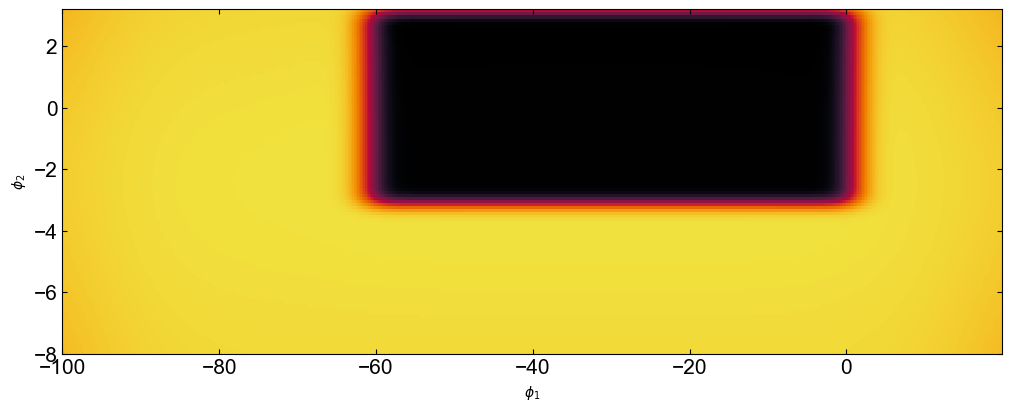

In [65]:
offtrack_model0 = GD1OffTrackModel(offtrack_init_p)
_ = offtrack_model0.plot_model_projections(grid_coord_names=[('phi1', 'phi2')])

# Mixture of all components

In [67]:
full_Components = [GD1StreamModel, GD1BackgroundModel, GD1OffTrackModel]
full_mix_params0 = {
    "stream": stream_opt_pars,
    "background": bkg_opt_pars,
    "offtrack": offtrack_init_p,
}

In [68]:
tied_params = [
    (("offtrack", "pm1"), ("stream", "pm1")),
    (("offtrack", "pm2"), ("stream", "pm2")),
]
full_mix_init = StreamMixtureModel(
    full_mix_params0, full_Components, tied_params=tied_params
)

In [69]:
full_mix_params0['offtrack'][('phi1', 'phi2')]['zs'].shape

(874,)

In [70]:
tied_params

[(('offtrack', 'pm1'), ('stream', 'pm1')),
 (('offtrack', 'pm2'), ('stream', 'pm2'))]

In [71]:
full_mix_opt_pars, info = StreamMixtureModel.optimize(
    data=run_data,
    Components=full_Components,
    #tied_params=tied_params,
    init_params=full_mix_params0,
    use_bounds=True,
)
full_mix_opt = StreamMixtureModel(full_mix_opt_pars, Components=full_Components)
info

ScipyMinimizeInfo(fun_val=Array(0.8825612, dtype=float64, weak_type=True), success=False, status=1, iter_num=8192, hess_inv=LbfgsInvHessProduct(sk=[[-2.66730636e-05 -7.66672818e-04  1.32935744e-05 ... -2.10519951e-04
   3.07439283e-04  1.22955310e-04]
 [-3.93340618e-05  3.24730493e-04  9.60648476e-06 ... -1.69322968e-04
   8.39532624e-05 -3.01523493e-05]
 [-6.47621525e-05  3.34133131e-04  1.21473517e-05 ... -2.87233878e-04
   1.28730896e-04 -2.43768390e-05]
 ...
 [ 1.87463506e-04 -8.91798870e-04 -1.58074621e-05 ... -1.28696499e-04
   9.41686877e-05  1.32099453e-04]
 [-4.15859676e-05 -2.08259948e-04  1.53371968e-05 ... -1.17976667e-04
   2.52608003e-04  3.66663234e-05]
 [ 8.70159711e-05 -4.05123763e-04  6.45214940e-07 ... -8.24084910e-05
   1.13395268e-04  6.20147203e-05]], yk=[[-1.90816229e-05 -1.55779250e-09  8.75247765e-09 ... -9.84184443e-06
   1.42918617e-05  8.90239823e-07]
 [-3.80156559e-05  4.12112569e-09  2.41457874e-07 ... -6.03493703e-06
   3.99055635e-06  3.32873584e-07]
 [-

(<Figure size 1000x400 with 1 Axes>,
 array([<Axes: xlabel='$\\phi_1$', ylabel='$\\phi_2$'>], dtype=object))

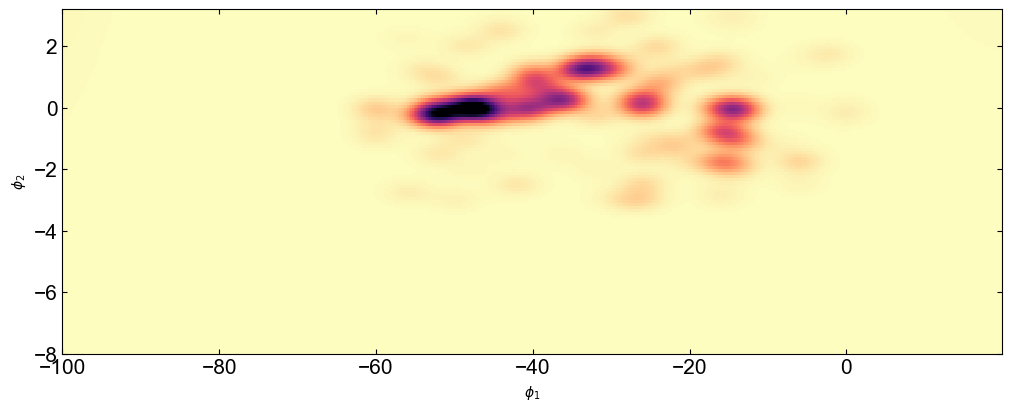

In [75]:
import copy
tmp_pars = copy.deepcopy(full_mix_opt_pars['offtrack'])
tmp_pars['pm1'] = full_mix_opt_pars['stream']['pm1'].copy()
tmp_pars['pm2'] = full_mix_opt_pars['stream']['pm2'].copy()
tmp = GD1OffTrackModel(tmp_pars)
tmp.plot_model_projections(
    grid_coord_names=[("phi1", "phi2")], pcolormesh_kwargs=dict(vmin=0, vmax=0.4, cmap='magma_r')
)

(<Figure size 1000x400 with 1 Axes>,
 array([<Axes: xlabel='$\\phi_1$', ylabel='$\\phi_2$'>], dtype=object))

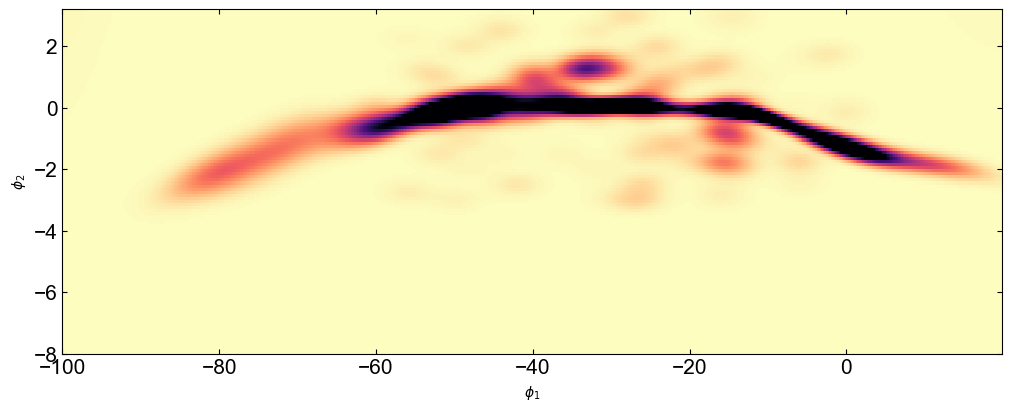

In [76]:
full_mix_nobkg_opt = StreamMixtureModel(
    full_mix_opt_pars, Components=[GD1StreamModel, GD1OffTrackModel], tied_params=tied_params
)
full_mix_nobkg_opt.plot_model_projections(
    grid_coord_names=[("phi1", "phi2")], pcolormesh_kwargs=dict(vmin=0, vmax=0.4, cmap='magma_r')
)

(<Figure size 1000x400 with 1 Axes>,
 array([<Axes: xlabel='$\\phi_1$', ylabel='$\\phi_2$'>], dtype=object))

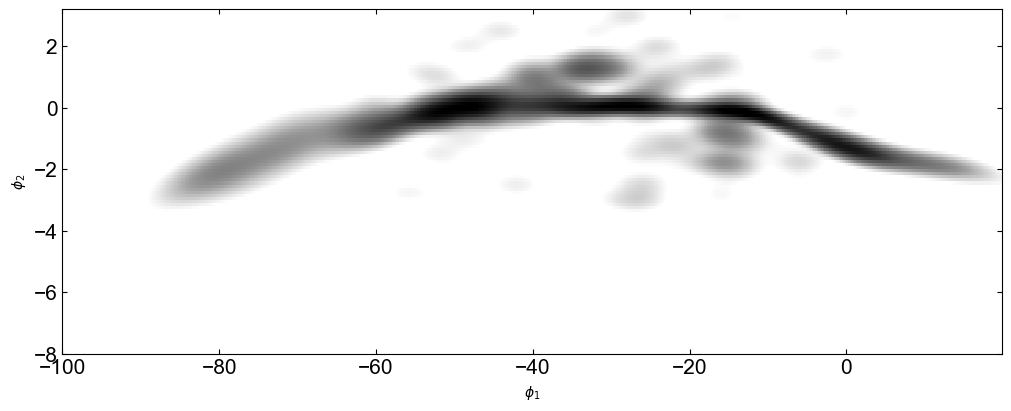

In [77]:
full_mix_nobkg_opt = StreamMixtureModel(
    full_mix_opt_pars, Components=[GD1StreamModel, GD1OffTrackModel], tied_params=tied_params
)
full_mix_nobkg_opt.plot_model_projections(
    grid_coord_names=[("phi1", "phi2")], pcolormesh_kwargs=dict(norm=mpl.colors.LogNorm(vmin=1e-2, vmax=1), cmap='Greys')
)

(<Figure size 800x800 with 3 Axes>,
 array([<Axes: ylabel='$\\phi_2$'>, <Axes: ylabel='$\\mu_{\\phi_1}$'>,
        <Axes: xlabel='$\\phi_1$', ylabel='$\\mu_{\\phi_2}$'>],
       dtype=object))

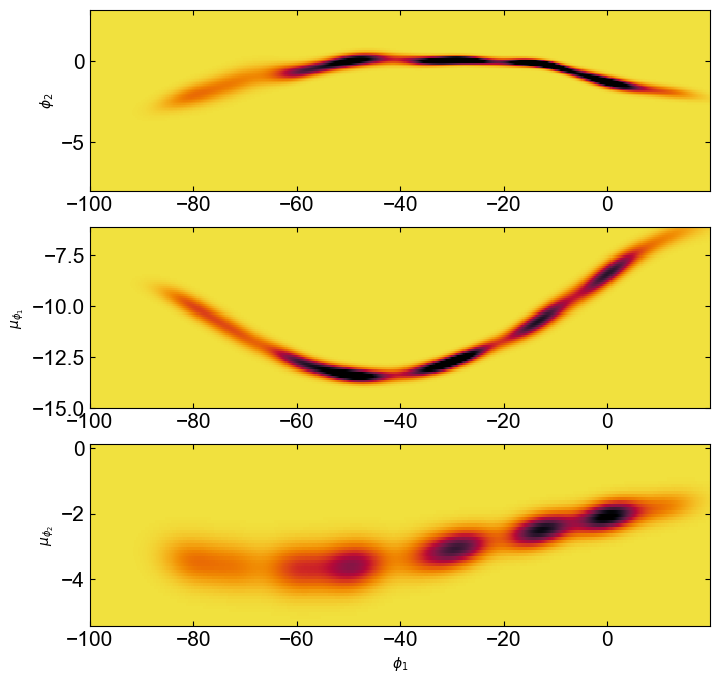

In [82]:
fig, axs = plt.subplots(3,1,figsize=(8,10))
full_stream_opt = GD1StreamModel(full_mix_opt_pars['stream'])
full_stream_opt.plot_model_projections(pcolormesh_kwargs=dict(vmin=0, vmax=0.5), axes=axs)

In [81]:
full_mix_opt_pars['stream']

{'ln_N': Array(7.03706969, dtype=float64),
 'phi1': {'zs': Array([-7.37626437, -7.6583479 , -8.        , -8.        , -8.        ,
         -5.02425777,  0.5406238 , -4.54503195,  0.32904079, -1.54314444,
         -3.79818606,  0.96765485, -1.88551909,  0.58504156,  1.19630787,
         -4.4654777 , -2.38322058,  0.14321783,  0.38679703,  1.396316  ,
         -7.07405701, -7.40611595,  0.31449392,  1.71531717, -6.42651825,
         -5.18321947,  3.16739992, -8.        ,  1.00957904,  8.        ,
          3.20953424,  0.85423195], dtype=float64)},
 'phi2': {'ln_std': Array([-0.87416611, -0.88409819, -0.87034153, -0.71859818, -0.77287848,
         -1.21673017, -1.39970243, -1.48266333, -1.74829516, -1.93707973,
         -1.93313831, -1.97178721, -1.63594016, -1.55971143, -1.52073622,
         -1.49376808], dtype=float64),
  'mean': Array([-3.08506317, -3.16330564, -2.46418878, -1.72245427, -0.94234142,
         -0.64553855, -0.10985543,  0.14784986,  0.0275281 ,  0.06451962,
         -0

TODO: how to plot projections for components where the x coord is in a joint, like OffTrack?

KeyError: 'phi1'

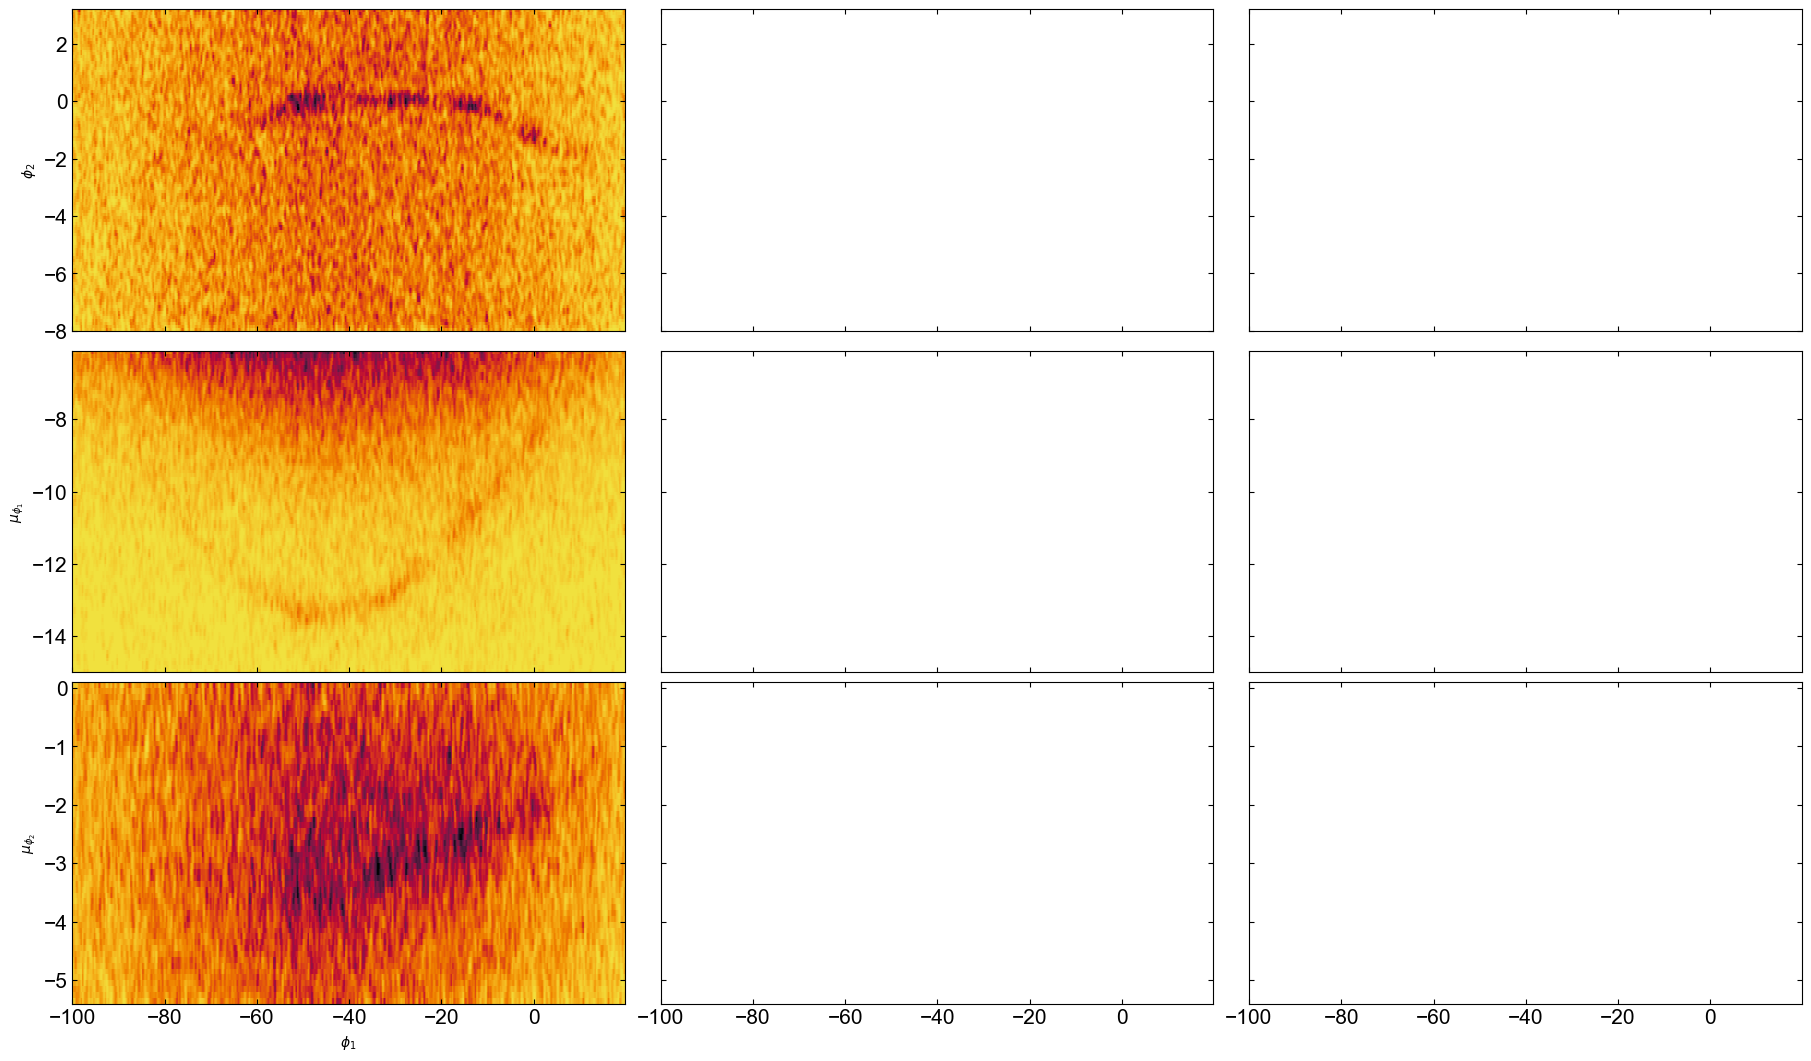

In [80]:
fig, axes = plt.subplots(
    len(stream_opt.coord_names) - 1,
    3, 
    figsize=(18, 3.5 * (len(stream_opt.coord_names) - 1)),
    sharex=True,
    sharey="row",
    constrained_layout=True,
)

axes = np.atleast_2d(axes)
plot_data_projections(
    data=run_data,
    grids=GD1Base.default_grids,
    axes=axes[:, 0],
)
full_mix_opt.plot_model_projections(axes=axes[:, 1])
full_mix_opt.plot_residual_projections(
    data=run_data, axes=axes[:, 2], pcolormesh_kwargs=dict(vmin=-1, vmax=1)
)

for ax in axes[-1]:
    ax.set_xlabel(r"$\phi_1$")